In [12]:
from jax_renderer_primitives import getProjectionMatrixJax, _build_rasterize_gaussians_fwd_primitive, _build_rasterize_gaussians_bwd_primitive
from diff_gaussian_rasterization import _C as torch_backend

import jax
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation as R
import functools
import matplotlib.pyplot as plt
import math
import numpy as np
from random import randint
from tqdm import tqdm
from time import time
import torch

In [13]:
key = jax.random.PRNGKey(67)
rasterizer_fwd_primitive = _build_rasterize_gaussians_fwd_primitive()
rasterizer_bwd_primitive = _build_rasterize_gaussians_bwd_primitive()

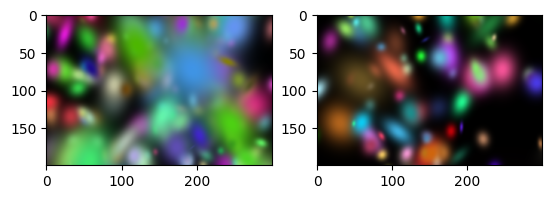

In [32]:
key = jax.random.split(key, 2)[0]


image_width, image_height, fx, fy, cx, cy, znear, zfar = 300, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
pmatrix = getProjectionMatrixJax(image_width, image_height, fx, fy, cx, cy, znear, zfar)
camera_pose_jax = jnp.eye(4)
view_matrix = jnp.transpose(jnp.linalg.inv(jnp.eye(4)))

projmatrix = view_matrix @ pmatrix

fovX = jnp.arctan(image_width / 2 / fx) * 2.0
fovY = jnp.arctan(image_height / 2 / fy) * 2.0
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)

bg = jnp.zeros(3)
campos = jnp.zeros(3)

N = 100
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
key = jax.random.split(key, 1)[0]
N = means3D.shape[0]
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)

num_rendered, color_gt, radii, geomBuffer, binningBuffer, imgBuffer = rasterizer_fwd_primitive.bind(
            bg,
            means3D,
            colors_precomp,
            opacity,
            scales,
            rotations,
            view_matrix,
            projmatrix,
            campos,
            tanfovx=tan_fovx, 
            tanfovy=tan_fovy, 
            image_height=image_height, 
            image_width=image_width,  
)

N = 200
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
key = jax.random.split(key, 1)[0]
N = means3D.shape[0]
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)

num_rendered, color, radii, geomBuffer, binningBuffer, imgBuffer = rasterizer_fwd_primitive.bind(
            bg,
            means3D,
            colors_precomp,
            opacity,
            scales,
            rotations,
            view_matrix,
            projmatrix,
            campos,
            tanfovx=tan_fovx, 
            tanfovy=tan_fovy, 
            image_height=image_height, 
            image_width=image_width,  
)
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color, (1,2,0)))
ax2.imshow(jnp.transpose(color_gt, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


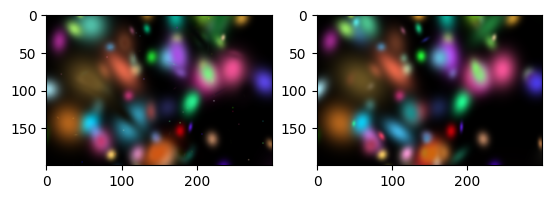

In [42]:
for _ in range(100):
    num_rendered, color, radii, geomBuffer, binningBuffer, imgBuffer = rasterizer_fwd_primitive.bind(
                bg,
                means3D,
                colors_precomp,
                opacity,
                scales,
                rotations,
                view_matrix,
                projmatrix,
                campos,
                tanfovx=tan_fovx, 
                tanfovy=tan_fovy, 
                image_height=image_height, 
                image_width=image_width,  
    )

    grad_out_color = jnp.array(color - color_gt)

    (dL_dmeans3D,
    dL_dmeans2D,
    dL_dcolors,
    dL_dconic,
    dL_dopacity,
    dL_dcov3D,
    dL_dsh,
    dL_dscales,
    dL_drotations) = rasterizer_bwd_primitive.bind(
                bg,
                means3D,
                radii,
                colors_precomp,
                scales,
                rotations,
                view_matrix,
                projmatrix,
                grad_out_color,
                campos,
                geomBuffer,
                num_rendered,
                binningBuffer,
                imgBuffer,
                tanfovx=tan_fovx, 
                tanfovy=tan_fovy,
    )


    colors_precomp = colors_precomp - dL_dcolors  * 0.0004
    means3D = means3D - dL_dmeans3D  * 0.00001
    scales = scales - dL_dscales  * 0.00001
    rotations = rotations - dL_drotations  * 0.00001
    # opacity = opacity - grad_opacities_jax  * 0.001
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color, (1,2,0)))
ax2.imshow(jnp.transpose(color_gt, (1,2,0)))